In [3]:
%matplotlib inline
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.datasets import make_swiss_roll
from helper_plot import hdr_plot_style
hdr_plot_style()

from copy import deepcopy as copy
from torch.distributions.normal import Normal

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from unet import UNet
import wandb
from PIL import Image

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything(0)

In [6]:
class Configs():
    
    n_epochs = 1_000
    n_steps = 1_000
    batch_size = 64
    lr = 2e-5
    data = 'MNIST' # FMNIST, CELEBA
    model = 'unet' # linear_shallow, linear_deep

In [7]:
c = Configs()

c.data = 'MNIST'
c.model = 'unet'

# Dataset

In [8]:
import torchvision
from torchvision.datasets import FashionMNIST, MNIST
from torchvision import transforms

In [9]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"
CELEB_A_PATH = "../../annotated_deep_learning_paper_implementations/data/celebA/img_align_celeba"

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [10]:
class CelebADataset(torch.utils.data.Dataset):
    """
    ### CelebA HQ dataset
    """

    def __init__(self, data_path: str, image_size: int):
        super().__init__()
        
        # List of files
        self._files = [os.path.join(data_path,p) for p in os.listdir(data_path)]

        # Transformations to resize the image and convert to tensor
        self._transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((image_size, image_size)),
            torchvision.transforms.ToTensor(),
        ])

    def __len__(self):
        """
        Size of the dataset
        """
        return len(self._files)

    def __getitem__(self, index: int):
        """
        Get an image
        """
        img = Image.open(self._files[index])
        return self._transform(img)

In [11]:
# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])

if c.data == 'MNIST':
    # Loading the training dataset. We need to split it into a training and validation part
    train_set = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
    test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)
    
elif c.data == 'FMNIST':
    # Loading the training dataset. We need to split it into a training and validation part
    train_set = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
    test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)
    
elif c.data == 'CELEBA':
    train_dataset = CelebADataset(data_path=CELEB_A_PATH, image_size=32)
    num_trains = int(len(os.listdir(CELEB_A_PATH))*.7)
    num_tests  = len(os.listdir(CELEB_A_PATH)) - num_trains
    train_set, test_set = torch.utils.data.random_split(train_dataset, [num_trains, num_tests])

/home/jeongseobkim/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=c.batch_size, shuffle=True, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=c.batch_size, shuffle=False, drop_last=False)

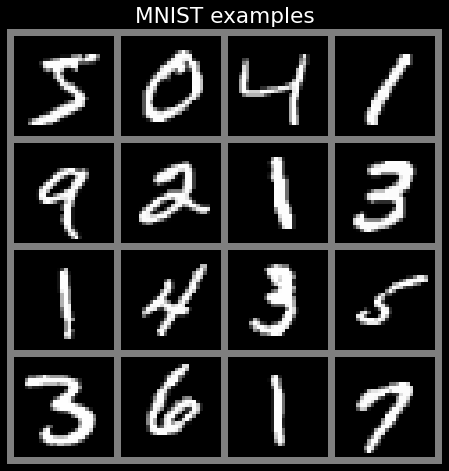

In [13]:
if c.data == 'CELEBA':
    exmp_imgs = [train_set[i] for i in range(16)]
else:
    exmp_imgs = [train_set[i][0] for i in range(16)]

# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, pad_value=.5, normalize=True) # |img_grid|=(3,122,122)
img_grid = img_grid.permute(1, 2, 0) #|img_grid|=(122,122,3)

plt.figure(figsize=(8,8))
plt.title(f"{c.data} examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()

# Try... A sample

## sample display

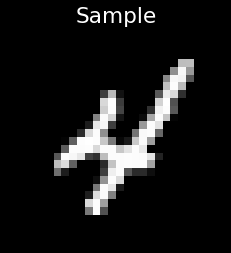

In [14]:
x = train_set[9][0]
plt.imshow(x.permute(1,2,0), cmap='gray')
plt.title(f'Sample')

plt.axis(False)
plt.show()

## Forward process

forward process에서는 data distribution $q(\mathbf{x}_{0})$는 점진적으로 analytically tractable한 $\pi(\mathbf{y})$ 분포로 변환된다. 이 변환 과정은 반복적인 Markvo diffusion kernel $T_{\pi}(\mathbf{y}\mid\mathbf{y}';\beta)$의 적용을 통해 이뤄진다.
- Markov diffusion kernel은 $\beta$라는 given 'diffusion rate'에 의해 정의됨

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = T_{\pi}(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}; \beta_{t})
$$

Markov diffusion kernel은 variance schedule $\beta_{1},\cdots,\beta_{T}$에 따라 점진적으로 Gaussian noise를 주입해가는 kernel을 의미한다. 수식은 아래와 같다.

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{1-\beta_{t}}\mathbf{x}_{t-1},\beta_{t}\mathbf{I})
$$

Markov chains 전 과정에 걸친 분포(the complete distribution) $q(\mathbf{x}_{0:T})$는 아래와 같은 _diffusion process_ 라고 불리운다.

$$
q(\mathbf{x}_{0:T}) =  q(\mathbf{x}_{0}) \prod_{t=1}^{T} q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})
$$


아래에서 단일 상수 분산(a constant variance)으로 'variance schedule'을 정의해 간단한 _forward diffusion process_ 를 구현해본다.

- 아래의 ```forward_process```는 gaussian distribution에서 sampling할 때, reparameterization을 진행하는 것을 참고해 아래와 같은 방식으로 구현한다.

$$x_{t} = \sqrt{1-\beta_{t}} x_{t-1} + \sqrt{\beta_{t}} * \epsilon$$

- stochasticity는 $\epsilon$ 에서 발생한다.
- $\beta$ 는 hyper-parameter로서(trainable X) 사전에 정의하는 variance scehdule에 따라 정의된다.

In [15]:
def forward_process(x_start, n_steps, noise=None):
    """ 
    Diffuse the data (t == 0 means diffused for 1 step) 
    
    x_start:tensor = dataset at start step(X_0)
    n_steps:int = the number of convert iterations in diffusion process
    """
    x_seq = [x_start] # initial 'x_seq' which is filled with origianl data at first.
    for n in range(n_steps):
        # Add gaussian noise with 'scaling with squared term and transition with beta * [0,1) unique dist'
        # Gaussian noise is '''torch.rand_like(x_start)''' in following code
        x_seq.append(torch.sqrt(1-noise[n])*x_seq[-1] + torch.sqrt(noise[n])*torch.rand_like(x_seq[-1]))
    return x_seq

In [16]:
n_steps = 100
betas = torch.tensor([0.03] * n_steps) # betas : variance schedule
x_seq = forward_process(x, n_steps, betas)

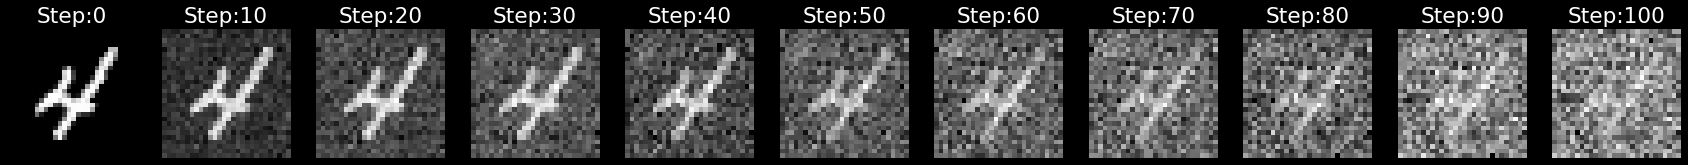

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(10*3, 3))
for i in range(11):
    step_shown = int(i%100)*n_steps//10  # 0, 10, 20, ... , 90, 100
    img = x_seq[step_shown].permute(1,2,0).to('cpu').numpy()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(f"Step:{step_shown}")
    axs[i].axis(False)

### beta scheduling(noise scheduling)

- **linear** schedule
- **Quad** schedule
- **Sigmoid**' schedule

In [18]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [19]:
def show_forward_results(x_seq, n_steps, num_interpolation=None):
    
    if num_interpolation is None:
        num_interpolation = 10
    show_steps = list(range(0, n_steps+1, int(n_steps/num_interpolation)))
    
    fig, axs = plt.subplots(nrows=1, ncols=len(show_steps), figsize=(len(show_steps)*4, 4))
    for i in range(len(show_steps)):
        img = x_seq[show_steps[i]].permute(1,2,0).to('cpu').numpy()
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Step:{show_steps[i]}")
        axs[i].axis(False)

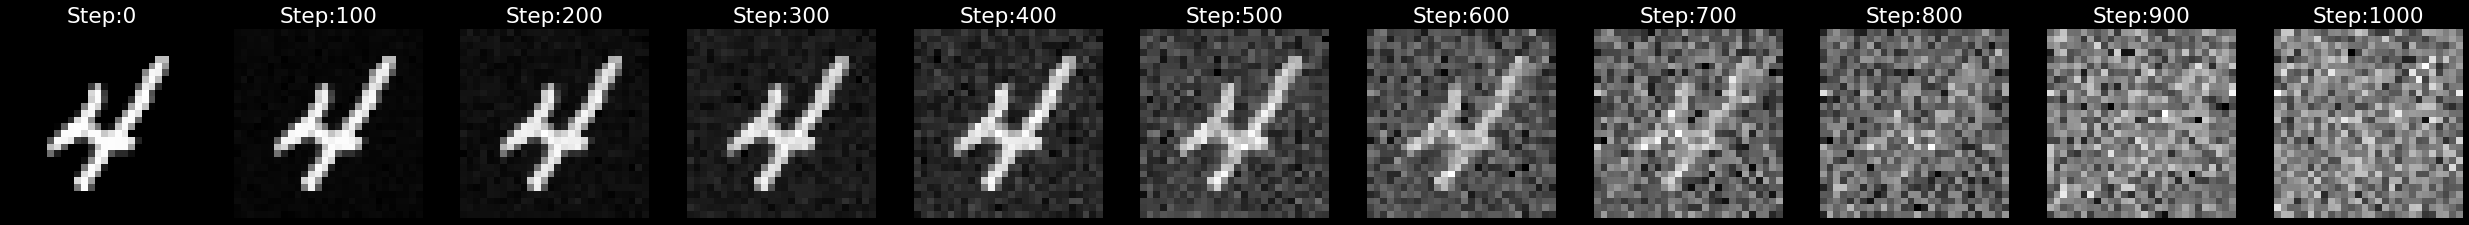

In [20]:
n_steps = c.n_steps
betas = make_beta_schedule('sigmoid', n_steps)
x_seq = forward_process(x, n_steps, betas)
show_forward_results(x_seq, n_steps, num_interpolation=None)

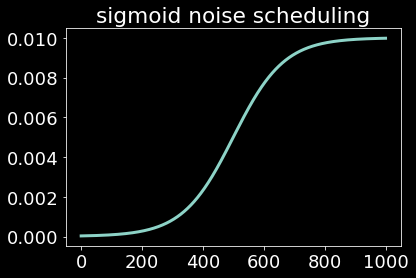

In [21]:
plt.plot(betas)
plt.title("sigmoid noise scheduling")
plt.show()

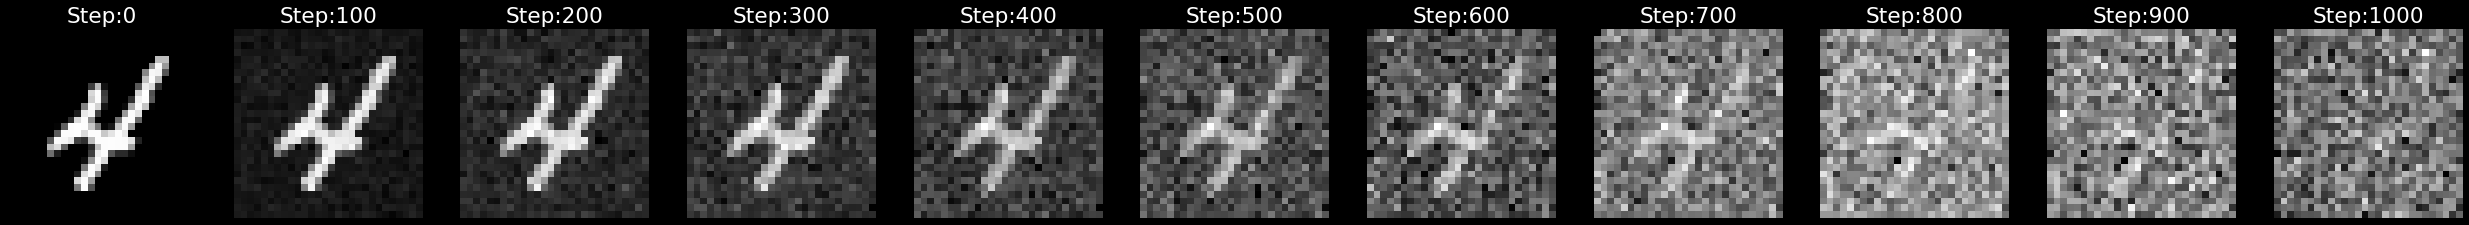

In [22]:
n_steps = c.n_steps
betas = make_beta_schedule('linear', n_steps)
x_seq = forward_process(x, n_steps, betas)
show_forward_results(x_seq, n_steps, num_interpolation=None)

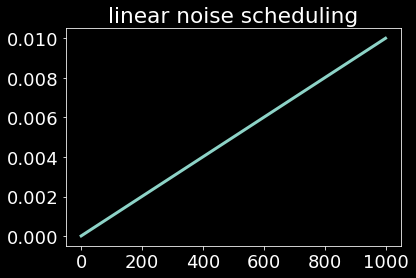

In [23]:
plt.plot(betas)
plt.title("linear noise scheduling")
plt.show()

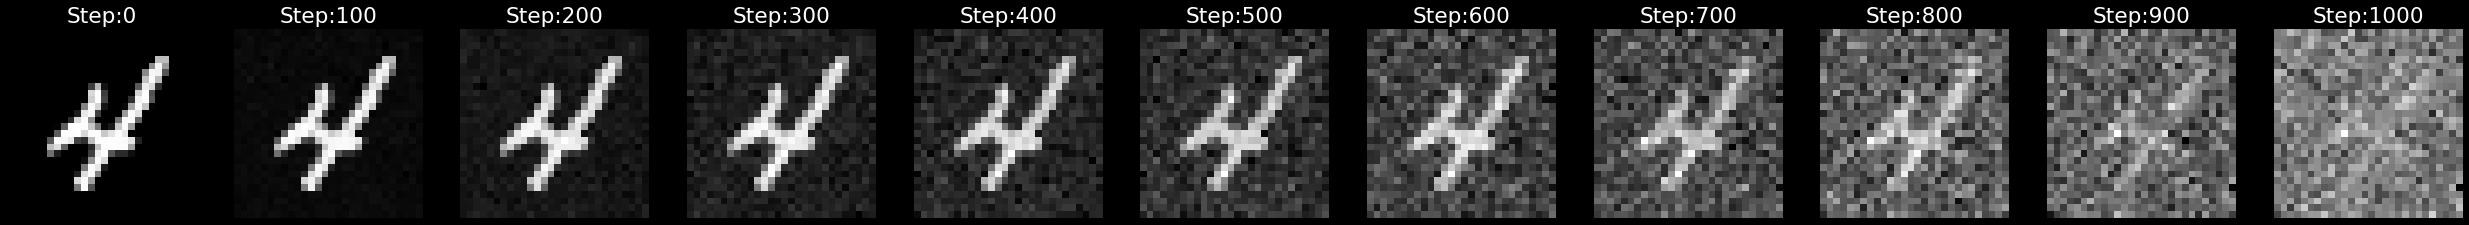

In [24]:
n_steps = c.n_steps
betas = make_beta_schedule('quad', n_steps)
x_seq = forward_process(x, n_steps, betas)
show_forward_results(x_seq, n_steps, num_interpolation=None)

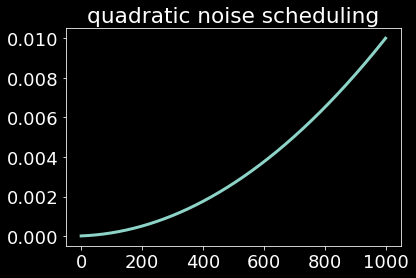

In [25]:
plt.plot(betas)
plt.title("quadratic noise scheduling")
plt.show()

### diffusion sampling at $t$ step

흥미롭게도, _forward process_ 는 sampling $\mathbf{x}_{t}$를 특정한 임의의 시점 $t$에서 가능하게 한다. Notation으로 $\alpha_{t}=1-\beta_{t}$와 $\bar{\alpha}_{t} = \prod_{s=1}^{t} \alpha_{s}$로 축약해 **시점 $t$에서의 $\mathbf{x}_{t}$ sampling을 아래와 같이 정리할 수 있다.**

$$
q(\mathbf{x}_{t}\mid\mathbf{x}_{0}) = \mathcal{N}(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0},(1-\bar{\alpha}_{t})\mathbf{I})
$$

- Original ipynb에서는 Sampling에 대한 수식이 위와 다르다. $q(\mathbf{x}_{t}\mid\mathbf{x}_{0})$이  $q(\mathbf{x}_{t}\mid\mathbf{x}_{t-1})$로, $\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0}$가 $\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{t-1}$로 제시되어있다. 이는 제 개인적인 판단에 따라 번역 중에 변형한 것이다. 아래 코드에서도 마찬가지로 ```q_sample```에서 입력 데이터($x_{0}$)를 받아 $t$시점의 diffused data sample을 반환하도록 되어있다. 그리고 이는 결국 입력 데이터에서 시작해 markov diffused kernel의 누적적인 영향($\sqrt{\bar{\alpha}}$)을 반영해 $t$시점의 diffused data sample을 반환하는 것이다. 따라서 위와 같이 입력 데이터를 조건부로 $t$시점의 diffused data sample을 반환하는 것으로 수식의 표기를 변경했다(만약, 위 해석과 변경에 오류가 있다면, 꼭 제 [이메일](jeongseob_kim@korea.ac.kr)로 연락주시면 감사드리겠습니다.). 


그러므로 우리의 diffusion sampling 함수를 이러한 mechanism에 따라 update할 수 있다. 잊지 말아야 할 것은 이러한 sampling mechanism은 사전적으로 정의한 variance schedule $\beta_{1},\cdots,\beta_{T}$에 따라 이뤄진다는 점이다.

In [26]:
def noise_scheduling(method='linear', n_timesteps=1000, start=1e-5, end=1e-2):
        
    betas = make_beta_schedule(method, n_steps, start, end)
    
    noise_set = dict()
    noise_set['betas'] = betas
    noise_set['alphas'] = 1 - betas
    noise_set['alphas_prod'] = torch.cumprod(noise_set['alphas'], 0)  # alphas_prod = Cumulative product of alphas
    noise_set['alphas_prod_p'] = torch.cat([torch.tensor([1]).float(), noise_set['alphas_prod'][:-1]], 0)
    noise_set['alphas_bar_sqrt'] = torch.sqrt(noise_set['alphas_prod'])
    noise_set['one_minus_alphas_bar_log'] = torch.log(1 - noise_set['alphas_prod'])
    noise_set['one_minus_alphas_bar_sqrt'] = torch.sqrt(1 - noise_set['alphas_prod'])
    
    return noise_set

In [27]:
n_steps = c.n_steps
noise_set = noise_scheduling('linear', n_steps)

이처럼 **시점 $t$에서의 $\mathbf{x}_{t}$ sampling**이 Markov diffusion kernel로서 정의된다는 점은 임의의 특정 $t$시점에서 혹은 원하는 아무 시점에서나 직접 sampling을 해낼 수 있게 한다는 점으로 매우 효율적인 forward process를 가능하게 한다. 아래와 같이 코드로 구현 가능하다.

In [28]:
def extract(input, t, x):
    '''
    Extract value 'alpha_bar_sqrt', 'one_minus_alpha_bar_sqrt' at any given 't' step.
    '''
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_sample(x_0, t, noise_set):
    '''
    Sampling at any given 't' step.
    '''
    noise = torch.randn_like(x_0)
    alphas_t = extract(noise_set['alphas_bar_sqrt'], t, x_0).to(device)
    alphas_1_m_t = extract(noise_set['one_minus_alphas_bar_sqrt'], t, x_0).to(device)

    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [29]:
def show_forward_sampling(x_seq, sampling_index, noise_set):
    
    q_i = q_sample(x_seq[sampling_index].to(device), torch.tensor([sampling_index]).to(device), noise_set)
    
    plt.figure(figsize=(2,2))
    plt.imshow(q_i.permute(1,2,0).to('cpu').numpy(), cmap='gray')
    plt.title(f'Step:{sampling_index}', fontsize=15)
    plt.axis(False)
    plt.show()

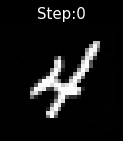

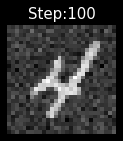

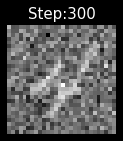

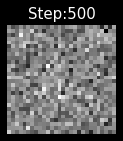

In [30]:
show_forward_sampling(x_seq, 0, noise_set)
show_forward_sampling(x_seq, 100, noise_set)
show_forward_sampling(x_seq, 300, noise_set)
show_forward_sampling(x_seq, 500, noise_set)

## Reverse

우리가 학습하고자 하는 생성적 분포(generative distribution)는 "reverse trajectory"를 수행하도록 학습될 것이다. 이 "reverse trajectory"는 gaussian noise에서 시작해 점진적으로 local perturbations들을 제거해나갈 것이다(denoising process). 그러므로 "reverse prcocess"는 주어진 tractable distribution $p(\mathbf{x}_{T})=\pi(\mathbf{x}_{T})$ 에서 시작할 것이다. 이는 아래와 같다.

$$
p_{\theta}(\mathbf{x}_{0:T}) =  p(\mathbf{x}_{T}) \prod_{t=1}^{T} p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t})
$$

해당 process("reverse")의 각 변환(transition)은 간단한 conditional gaussians(VAE를 연상시키는)로 정의된다. 그러므로 학습 동안에는, 해당 transition(conditional gaussians = Gaussian diffusion kernel)의 mean과 covariance이 학습되게 된다.

$$
p_{\theta}(\mathbf{x}_{t-1}\mid\mathbf{x}_{t}) = \mathcal{N}(\mathbf{x}_{t-1} ; \mathbf{\mu}_{\theta}(\mathbf{x}_{t},t),\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t))
$$

mean $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ 과 covariance $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ 을 정의하는 두 함수는 Deep Neural Network로 정의될 수 있다. 주목할 점은 위의 두 function($\mathbf{\mu}_{\theta}$, $\mathbf{\Sigma}_{\theta}$) 모두 $t$로 parameterized 된다는 점이다. 모두 $t$로 parameterized 된다는 점은 곧 단일 모델(single model)이 모든 time-steps에 대해 사용될 수 있다는 점을 의미한다.

"reverse process"는 given time-step의 mean, log variance를 추론하는 것으로 구성된다. 그렇다면, 우리는 해당하는 모델을 한 번 학습하게 되면, 어떠한 주어진 time-step에 대해서도 denoising(reverse process)을 수행할 수 있다는 것을 의미한다. 이 경우 주어진 time-step과 그 step의 sample $\mathbf{x}_{t}$ 를 토대로 denoising이 수행되고, 이는 $\mathbf{\mu}_{\theta}(\mathbf{x}_{t},t)$ and $\mathbf{\Sigma}_{\theta}(\mathbf{x}_{t},t)$ 를 학습함으로써 가능해진다.

### DDPM

#### Reverse process

최근 연구(Ho et al)에서는 생성 결과물의 품질을 향상시키는 몇몇 개선점을 포함한 diffusion model들이 제안되었다. 첫 째로, 'mean function'에 대해 아래처럼 parameterization을 제안했다.

$$
\mathbf{\mu}_{\theta}(\mathbf{x}_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}} \left( (\mathbf{x}_{t} - \frac{\beta_{t}}{\sqrt{1 - \bar{\alpha}}_{t}} \mathbf{\epsilon}_{\theta} (\mathbf{x}_{t}, t) \right) 
$$

- because..

$$
\mathbf{x}_{t} \sim q\left(\mathbf{x}_{t} \mid \mathbf{x}_{0}\right)=\mathcal{N}\left(\mathbf{x}_{t} ; \sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0},\left(1-\bar{\alpha}_{t}\right) \mathbf{I}\right)
$$

$$
\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)=\sqrt{\bar{\alpha}_{t}} \mathbf{x}_{0}+\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon} \text { for } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$

$$
\mathbf{x}_{0} = \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(\mathbf{x}_{t}\left(\mathbf{x}_{0}, \boldsymbol{\epsilon}\right)-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}\right)
$$

$$
\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right)=\tilde{\boldsymbol{\mu}}_{t}\left(\mathbf{x}_{t}, \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(\mathbf{x}_{t}-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}\right)\right)\right)=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)
$$

모델은 noise function의 형식으로 직접 output을 뱉어내도록 학습된다. 이 noise function은 sampling process에서 사용된다. 게다가 저자는 fixed variance function을 사용하도록 제안한다.

$$
\mathbf{x}_{t-1} = \mu_{\theta}(x_{t}, t) + \sigma_{t}\mathbf{z} = \frac{1}{\sqrt{\alpha_{t}}} \left( \mathbf{x}_{t} - \frac{1-\alpha_{t}}{\sqrt{1-\bar{\alpha_{t}}}} \mathbf{\epsilon}_{\theta}(\mathbf{x}_{t}, t) \right) + \sigma_{t}\mathbf{z}, \space\space\space \mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
$$


- because..
$$
\mathbf{x}_{t-1} \sim p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right), \mathbf{\Sigma}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)
$$

이는 reverse process에서 새로운 sampling procedure로 이어진다. 

##### Sampling

In [31]:
@torch.no_grad()
def p_sample(model, x, t, noise_set):
    
    t = torch.tensor([t]).to(device)
    
    # Factor to the model output
    eps_factor = ((1 - extract(noise_set['alphas'], t, x)) / extract(noise_set['one_minus_alphas_bar_sqrt'], t, x)).to(device)
    
    # Model output
    eps_theta = model(x, t)
    
    # Final values
    mean = (1 / extract(noise_set['alphas'].to(device), t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x).to(device)
    
    # Fixed sigma
    sigma_t = extract(noise_set['betas'], t, x).sqrt().to(device)
    sample = mean + sigma_t * z
    
    return (sample)


def p_sample_loop(model, shape, noise_set):
    shape = tuple([1]+list(shape))
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, noise_set)
        x_seq.append(cur_x.detach())
    return x_seq

##### Models

In [32]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [33]:
class ConditionalLinearModel_shallow(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(28*28, 28*28*2, n_steps)
        self.lin2 = ConditionalLinear(28*28*2, 28*28*2, n_steps)
        self.lin3 = nn.Linear(28*28*2, 28*28)
    
    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x, y))
        x = F.relu(self.lin2(x, y))
        x = self.lin3(x)
        x = x.view(-1, 28, 28)
        return x
    

class ConditionalLinearModel_deep(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.lin1 = ConditionalLinear(28*28, 28*28*2, n_steps)
        self.dr1 = nn.Dropout(p=0.5)
        self.lin2 = ConditionalLinear(28*28*2, 28*28*4, n_steps)
        self.lin3 = ConditionalLinear(28*28*4, 28*28*6, n_steps)
        self.dr3 = nn.Dropout(p=0.5)
        self.lin4 = ConditionalLinear(28*28*6, 28*28*8, n_steps)
        self.lin5 = ConditionalLinear(28*28*8, 28*28*6, n_steps)
        self.dr5 = nn.Dropout(p=0.5)
        self.lin6 = ConditionalLinear(28*28*6, 28*28*4, n_steps)
        self.lin7 = ConditionalLinear(28*28*4, 28*28*2, n_steps)
        self.dr7 = nn.Dropout(p=0.5)
        self.lin8 = nn.Linear(28*28*2, 28*28)
    
    def forward(self, x, y):
        x = x.view(x.size(0), -1)  # flatten x for MLP
        x = F.relu(self.lin1(x, y))
        x = self.dr1(x)
        x = F.relu(self.lin2(x, y))
        x = F.relu(self.lin3(x, y))
        x = self.dr3(x)
        x = F.relu(self.lin4(x, y))
        x = F.relu(self.lin5(x, y))
        x = self.dr5(x)
        x = F.relu(self.lin6(x, y))
        x = F.relu(self.lin7(x, y))
        x = self.dr7(x)
        x = self.lin8(x)
        x = x.view(-1, 28, 28)
        
        return x

In [34]:
if c.model == 'linear_shallow':
    model = ConditionalLinearModel_shallow(c.n_steps).to(device)
elif c.model == 'linear_deep':
    model = ConditionalLinearModel_deep(c.n_steps).to(device)
elif c.model == 'unet':
    if c.data == 'CELEBA':
        model = UNet(image_channels=1, n_channels=64, ch_mults=[1, 2, 2, 4], is_attn=[False, False, False, True]).to(device)
    else:
        model = UNet(image_channels=1, n_channels=64, ch_mults=[1, 2, 4], is_attn=[True, True, True]).to(device)

#### Loss simplification

저자는 loss의 시작 시기에 있는 복잡한 부분(complicated factor)를 완전히 제거하는 것이 sample의 질에 상호 호혜적이라는 점을 의논한다. 이러한 논의는 결국 objective를 아래와 같이 요약한다.

$$
\mathcal{L}_{\text{simple}}=\mathbb{E}_{t, \mathbf{x}_{0},\mathbf{\epsilon}}\left[ \Vert \epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha}_{t}}\mathbf{x}_{0} + \sqrt{1 - \bar{\alpha}_{t}}\mathbf{\epsilon}, t) \Vert^{2} \right].
$$

이 objective는 denoising score matching 공식과 매우 유사함을 알 수 있다. 게다가 이는 굉장히 간단하게 코드 구현이 가능하다.

In [35]:
def noise_estimation_loss(model, x_0, noise_set):
    batch_size = x_0.shape[0]
    
    # Select a random step for each example of a batch
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long().to(device)
    
    # x0 multiplier
    a = extract(noise_set['alphas_bar_sqrt'], t, x_0).to(device)
    
    # eps multiplier
    am1 = extract(noise_set['one_minus_alphas_bar_sqrt'], t, x_0).to(device)
    e = torch.randn_like(x_0).to(device)
    
    # model input
    x = x_0 * a + e * am1 # |x| = (n_c, n_h, n_w)
    x = x.view(tuple([-1]+list(x.size()))) # |x| = (n_b, n_c, n_h, n_w)
    
    output = model(x, t)  # model := e_{epsilon}(x, t) 
    
    return (e - output).square().mean()

#### Stabilizing training with Exponential Moving Average (EMA) 

EMA 아이디어는 _model momentum_ 을 가능하게 하며, 거의 대부분의 구현체에서 사용되는 테크닉이다. 

모델의 weights를 직접 upate하는 대신, 우리는 weigts의 이전 process의 value들을 먼저 복사해 저장("shadow")해둔다. 그리고 과거와 현재의 weight값들을 서로 가중평균해 모델의 weights 예측을 update한다.

$$w_{1:t} = (1-\mu) \cdot w_{t} + \mu \cdot w_{1:(t-1)}, \space\space\space ex) \space \mu = 0.9$$

해당 코드는 [DDIM repository](https://github.com/ermongroup/ddim)를 참고해 작성됐다.

- [code](https://github.com/ermongroup/ddim/blob/51cb290f83049e5381b09a4cc0389f16a4a02cc9/runners/diffusion.py#L192)
    - Sample 과정에서 학습 시 저장해놓은 ema parameters들을 load해 사용할 수 있음
    - 현재 ipynb에서는 사용하지는 않음

In [34]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = torch.tensor(mu).to(device)
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone().to(device)

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

## Train

아래의 training loop를 통해 최적화를 할 수 있다.

```python
model, optimizer, dataset 선언
EMA model 생성

for Iterations 1000:
    
    for batch:
        
        loss 계산
        loss.backward
        
        weight update
        EMA update(weight moving average)

        
    if Iteration % 100 == 0:
       
        print(loss)
        reverse sampling 결과 visualization($x_{100}, ..., x_{1000}$)
```

In [35]:
optimizer = optim.Adam(model.parameters(), lr=c.lr)

In [36]:
# Create EMA model
ema = EMA(0.9)
ema.register(model)

In [37]:
# wandb
wandb.init(project="Diffusion_mnist", entity="jskim0406", name=f'data-{c.data}_model-{c.model}_nepochs-{c.n_epochs}.pkl')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jskim0406. Use `wandb login --relogin` to force relogin


In [38]:
x_seq_gen = []
noise_set = noise_scheduling('linear', c.n_steps)

losses = []

for t in tqdm(range(c.n_epochs)):
    
    # Compute the loss.
    loss = noise_estimation_loss(model, x.to(device), noise_set)
    
    # Before the backward pass, zero all of the network gradients
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()

    # Perform gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)

    # Calling the step function to update the parameters
    optimizer.step()

    # Update the exponential moving average
    ema.update(model)
    losses.append(float(loss))
    wandb.log({'train_loss': loss.item()})
    
    if t%int(1e+2)==0:
        print(f'EPOCH {t} | LOSS : {loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 0 | LOSS : 1.030049204826355
EPOCH 100 | LOSS : 1.070574164390564
EPOCH 200 | LOSS : 0.9245365262031555
EPOCH 300 | LOSS : 1.062078595161438
EPOCH 400 | LOSS : 1.0152812004089355
EPOCH 500 | LOSS : 1.0059943199157715
EPOCH 600 | LOSS : 0.9392159581184387
EPOCH 700 | LOSS : 1.0615737438201904
EPOCH 800 | LOSS : 1.0415328741073608
EPOCH 900 | LOSS : 0.9556788206100464


# Save and load model

In [39]:
# state_dict = model.state_dict()
# torch.save(state_dict, os.path.join(CHECKPOINT_PATH, f'data-{c.data}_model-{c.model}_nepochs-{c.n_epochs}.pkl'))

In [36]:
c.model = 'unet'
c.data  = 'MNIST'

In [37]:
state_dict_loaded = torch.load(os.path.join(CHECKPOINT_PATH, f'data-{c.data}_model-{c.model}_nepochs-{c.n_epochs}.pkl'))

In [38]:
if c.model == 'linear_shallow':
    loaded_model = ConditionalLinearModel_shallow(c.n_steps).to(device)
elif c.model == 'linear_deep':
    loaded_model = ConditionalLinearModel_deep(c.n_steps).to(device)
elif c.model == 'unet':
    if c.data == 'CELEBA':
        loaded_model = UNet(image_channels=1, n_channels=64, 
                            ch_mults=[1, 2, 2, 4], is_attn=[True, True, True, True]).to(device)
    else:
        loaded_model = UNet(image_channels=1, n_channels=64, 
                            ch_mults=[1, 2, 4], is_attn=[True, True, True]).to(device)
        
loaded_model.load_state_dict(state_dict_loaded)

<All keys matched successfully>

# Sampling

```python
@torch.no_grad()
def p_sample(model, x, t, noise_set):
    
    t = torch.tensor([t]).to(device)
    
    # Factor to the model output
    eps_factor = ((1 - extract(noise_set['alphas'], t, x)) / extract(noise_set['one_minus_alphas_bar_sqrt'], t, x)).to(device)
    
    # Model output
    eps_theta = model(x, t)
    
    # Final values
    mean = (1 / extract(noise_set['alphas'].to(device), t, x).sqrt()) * (x - (eps_factor * eps_theta))
    
    # Generate z
    z = torch.randn_like(x).to(device)
    
    # Fixed sigma
    sigma_t = extract(noise_set['betas'], t, x).sqrt().to(device)
    sample = mean + sigma_t * z
    
    return (sample)


def p_sample_loop(model, shape, noise_set):
    shape = tuple([1]+list(shape))
    cur_x = torch.randn(shape).to(device)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, noise_set)
        x_seq.append(cur_x.detach())
    return x_seq
```

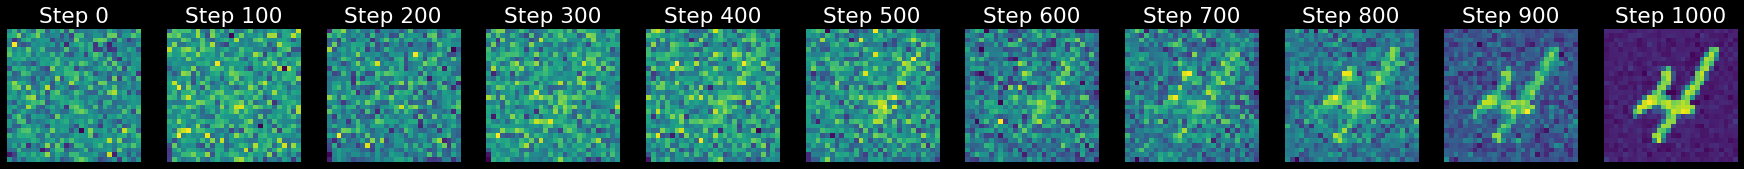

In [39]:
x_seq_gen = p_sample_loop(loaded_model, x.shape, noise_set)

fig, axs = plt.subplots(nrows=1, ncols=11, figsize=(31,3))
for i in range(11):
    sample = x_seq_gen[i*100].detach()
    axs[i].imshow(sample[0].permute(1,2,0).to('cpu').numpy())
    axs[i].set_title(f"Step {i*100}")
    axs[i].axis(False)

plt.show()